In [1]:
from mylib.statistic_test import *
from scipy.stats import nbinom, gamma, poisson
from mylib.model import ContinuousHiddenStateModel
code_id = '0349 - Simulated Coordination'
loc = join(figpath, code_id)
mkdir(loc)

with open(r"E:\Data\FinalResults\0346 - GLM for all sessions\10227_MA_iter1.pkl", 'rb') as handle:
    models, _ = pickle.load(handle)
    
model: ContinuousHiddenStateModel = models[-4]

class GammaPoissonModel:
    def __init__(self, n_neuron = 500, alpha = 5.3, beta = 9.4) -> None:
        self.n_neuron = n_neuron
        self.a = alpha
        self.b = beta
        
        self.propensity = gamma.rvs(self.a, scale=1/self.b, size=self.n_neuron)
        self.field_num = self.generate_field_num()
            
    def get_field_num_sum(self):
        return int(np.sum(self.field_num))
    
    def generate_field_num(self):
        field_num = np.zeros(self.n_neuron)
        for n in range(self.n_neuron):
            field_num[n] = poisson.rvs(self.propensity[n] * 9)
        return field_num.astype(np.int64)
        
    @staticmethod
    def get_field_num(n_neuron = 500, alpha = 5.3, beta = 9.4) -> 'GammaPoissonModel':
        model = GammaPoissonModel(n_neuron, alpha, beta)
        return model

class SFERCorrection:
    def __init__(
        self, 
        sfer_model: ContinuousHiddenStateModel, 
        n_neuron = 500, 
        n_day = 26,
        is_propensity = True
    ) -> None:
        self.GPM = GammaPoissonModel.get_field_num(n_neuron = n_neuron)
        self.field_num = self.GPM.field_num
        self.SFERM = sfer_model
        self.nn = n_neuron
        self.nd = n_day
        self.propensity = self.GPM.propensity
        self.stability = np.random.normal(0, 0.5, self.nn)
    
    def simulation_old(self):
        print(f"Total number of fields: {self.GPM.get_field_num_sum()}")
        self.field_reg = self._check_permanent_silent(np.vstack(
            self.SFERM.simulate(sequences=[np.arange(self.nd) for i in range(self.GPM.get_field_num_sum())])
        ))
        self.field_reg = np.vstack(self.field_reg)
        self.field_info = np.concatenate([np.repeat(i, self.field_num[i]) for i in range(self.nn)])
        
        assert self.field_reg.shape[0] == self.field_info.shape[0]
        
        for i in tqdm(range(1, self.nd)):
            # Calculate the expectation for new-field formation
            prev_num = np.zeros(self.nn)
            for j in range(self.nn):
                prev_num[j] = np.sum(self.field_info == j)
                
            p_res = self.calc_field_formation_gradient(prev_num)
            df = np.sum(self.field_reg[:, i-1]) - np.sum(self.field_reg[:, i]) 
            
            if df <= 0:
                continue
            
            #n_neuron = np.random.choice(np.arange(self.nn), p=p_res, size=df, replace=True)
            n_neuron = np.random.choice(np.arange(self.nn), size=df)
            append_reg = np.zeros((df, self.nd), np.int64)
            simulated_seq = self.SFERM.simulate(sequences=[np.arange(self.nd-i) for _ in range(df)])
            
            if df == 1:
                append_reg[:, i:] = self._check_permanent_silent(simulated_seq[0][np.newaxis, :])[0]
            else:
                simulated_seq = np.vstack(simulated_seq)
                append_reg[:, i:] = self._check_permanent_silent(simulated_seq)
                
            self.field_reg = np.vstack([self.field_reg, append_reg])
            self.field_info = np.concatenate([self.field_info, n_neuron])
            
    def _sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
        
    def simulate(self, types = 1):
        field_reg = np.zeros((np.sum(self.field_num), self.nd), np.int64)
        field_reg[:, 0] = 1
        p = np.zeros_like(field_reg, np.float64)
        p[:, 0] = np.repeat(self.SFERM.p0, field_reg.shape[0])
        field_info = np.concatenate([np.repeat(i, self.field_num[i]) for i in range(self.nn)])
        field_pos = np.random.choice(np.arange(1, 2305), np.sum(self.field_num))
        
        is_permanent_silent = np.zeros(field_info.shape[0])
        for i in tqdm(range(1, self.nd)):
            # Corrected P
            
            p_temp = np.zeros(p.shape[0])
            #stability = self.stability[field_info]
            #p[:, i-1] = np.clip((1 - stability) * p[:, i-1] + stability, 1e-8, 1 - 1e-8)
            """
            for j in range(field_reg.shape[0]):
                idx = np.where(
                    (field_info == field_info[j])&
                    (is_permanent_silent < 8) &
                    (field_reg[:, i-1] == 1)
                )[0]
                idx = idx[idx != j]
                
                if idx.shape[0] > 0:
                    p_temp[j] = (1 - 0.2) * p[j, i-1] + 0.2 * np.mean(p[idx, i-1])
            
            p[:, i-1] = p_temp
            
            # Day-to-day fluctuation
            for j in range(self.nn):
                idx = np.where(field_info == j)[0]
                if idx.shape[0] > 0:
                    p[idx, i-1] = np.clip(p[idx, i-1] + np.random.normal(0, 0.5, idx.shape[0]), 1e-8, 1-1e-8)
            """    
            # Generate State
            for j in range(p.shape[0]):
                if is_permanent_silent[j] < 8:
                    field_reg[j, i] = np.random.choice([0, 1], p=[1 - p[j, i-1], p[j, i-1]])
            # Predict p
            p[:, i] = self.SFERM.predict(field_reg[:, i], p[:, i-1])
            
            # Update Field State
            is_permanent_silent[field_reg[:, i] == 0] += 1
            is_permanent_silent[field_reg[:, i] == 1] = 0
            
            # Append new field
            prev_num = np.zeros(self.nn)
            for j in range(self.nn):
                prev_num[j] = np.sum(field_info == j)
                
            p_res = self.calc_field_formation_gradient(prev_num)
            df = np.sum(field_reg[:, i-1]) - np.sum(field_reg[:, i]) 
            if df <= 0:
                continue
            
            #n_neuron = np.random.choice(np.arange(self.nn), p=p_res, size=df, replace=True)
            n_neuron = np.random.choice(np.arange(self.nn), size=df)
            append_reg = np.zeros((df, self.nd), np.int64)
            append_reg[:, i] = 1
            
            if df == 1:
                field_reg = np.vstack([field_reg, append_reg[np.newaxis, :]])
            else:
                field_reg = np.vstack([field_reg, append_reg])
            
            field_info = np.concatenate([field_info, n_neuron])
            field_pos = np.concatenate([field_pos, np.random.choice(np.arange(1, 2305), df)])
            is_permanent_silent = np.concatenate([is_permanent_silent, np.zeros(df)])
            p = np.vstack([p, np.ones((df, self.nd), np.float64) * self.SFERM.p0])
        
        self.field_reg = field_reg
        self.field_info = field_info
        self.field_pos = field_pos
        self.predicted_prob = p
        return field_reg, field_info, field_pos
    
    def calc_field_formation_gradient(self, field_num):
        propensity = self.GPM.propensity
        
        p_res = np.zeros(field_num.shape[0])
        for i in range(field_num.shape[0]):
            p_res[i] = (1 - poisson.cdf(field_num[i], propensity[i] * 9))*propensity[i]
        
        p_res = p_res / np.sum(p_res)
        return p_res
        
    
    def _check_permanent_silent(self, field_reg):
        for i in range(field_reg.shape[0]):
            I = 0
            for j in range(field_reg.shape[1]):
                if field_reg[i, j] == 0:
                    I += 1
                else:
                    I = 0
                
                if I >= 9:
                    field_reg[i, j:] = 0
        
        return field_reg
            
        
if __name__ == '__main__':
    n_neuron = 500
    alpha = 10
    beta = 8.5
    sfer_model: ContinuousHiddenStateModel = models[-4]
    #field_reg = sfer_model.simulate_across_day(n_step=26, n_fields=2500)[0]
    SFER = SFERCorrection(sfer_model, n_neuron, n_day=7)
    field_reg, field_info, field_center = SFER.simulate()
    #print(SFER.field_reg.shape)
    #field_centers = np.random.choice(np.arange(1, 2305), size = SFER.field_reg.shape[0])

e:\Anaconda\envs\maze\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda
Using device: cuda
Using device: cuda
        E:\Data\FinalResults\0349 - Simulated Coordination is already existed!


100%|██████████| 6/6 [00:00<00:00,  6.64it/s]


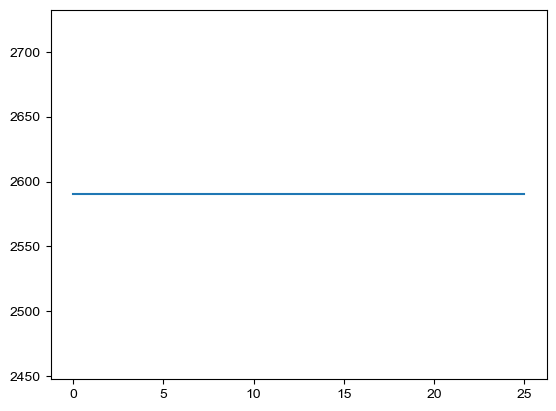

In [18]:
field_num_day = np.nansum(field_reg, axis = 0)
plt.plot(field_num_day)

# Pure SFER

In [2]:
from mylib.field.field_tracker import indept_test_for_evolution_events, compute_joint_probability_matrix

D = GetDMatrices(1, 48)
thre = 50

# Pure SFER
field_reg[np.isnan(field_reg)] = 0
print(field_reg.dtype)
field_info = np.random.choice(np.arange(500), size=field_reg.shape[0], replace=True)
field_centers = np.random.choice(np.arange(1, 2305), size = field_reg.shape[0])

sib_field_pairs, non_field_pairs = [], []
for i in tqdm(range(len(field_info)-1)):
    for j in range(i+1, len(field_info)):
        if field_info[i] == field_info[j]:
            if len(sib_field_pairs) >= 3000000:
                continue
            if D[int(field_centers[i])-1, int(field_centers[j])-1] <= thre:
                continue
                    
            sib_field_pairs.append([i, j])
            sib_field_pairs.append([j, i])
        else:
            if len(non_field_pairs) >= 200000000:
                continue
            non_field_pairs.append([i, j])
            non_field_pairs.append([j, i])
                
sib_field_pairs = np.array(sib_field_pairs)
non_field_pairs = np.array(non_field_pairs)

float64


100%|██████████| 11723/11723 [01:25<00:00, 136.60it/s] 


100%|██████████| 11723/11723 [03:38<00:00, 53.69it/s] 


In [4]:
session, mat = compute_joint_probability_matrix(
            field_reg.astype(np.float64).T,
            field_info,
            dim=2,
            return_item='sib',
            field_centers=field_centers,
            sib_field_pairs=sib_field_pairs,
            non_field_pairs=non_field_pairs
)
session, mat2 = compute_joint_probability_matrix(
            field_reg.astype(np.float64).T,
            field_info,
            dim=2,
            return_item='non',
            field_centers=field_centers,
            sib_field_pairs=sib_field_pairs,
            non_field_pairs=non_field_pairs
)

 init size  (233178, 2) (137164344, 2)
 after processed size  (25422, 2) (25422, 2)
 after processed size  (24502, 2) (24502, 2)
 after processed size  (24366, 2) (24366, 2)
 after processed size  (23128, 2) (23128, 2)
 after processed size  (22736, 2) (22736, 2)
 after processed size  (22730, 2) (22730, 2)
 after processed size  (22438, 2) (22438, 2)
 after processed size  (22256, 2) (22256, 2)
 after processed size  (22184, 2) (22184, 2)
 after processed size  (21748, 2) (21748, 2)
 after processed size  (21818, 2) (21818, 2)
 after processed size  (21928, 2) (21928, 2)
 after processed size  (21672, 2) (21672, 2)
 after processed size  (20926, 2) (20926, 2)
 after processed size  (21644, 2) (21644, 2)
 after processed size  (21802, 2) (21802, 2)
 after processed size  (21702, 2) (21702, 2)
 after processed size  (21382, 2) (21382, 2)
 after processed size  (21342, 2) (21342, 2)
 after processed size  (20710, 2) (20710, 2)
 after processed size  (20676, 2) (20676, 2)
 after processed

(25, 3, 3) (25, 3, 3)


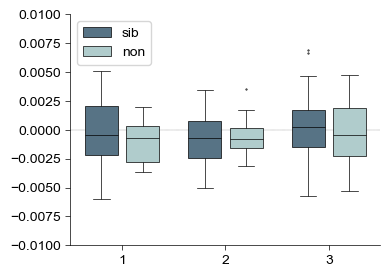

In [18]:
print(mat.shape, mat2.shape)
t = np.concatenate([np.arange(25)] * 3)
x = np.concatenate([np.repeat(1, 25), np.repeat(2, 25), np.repeat(3, 25)])
y1 = np.concatenate([mat[:, 0, 0], mat[:, 1, 1], mat[:, 2, 2]])
y2 = np.concatenate([mat2[:, 0, 0], mat2[:, 1, 1], mat2[:, 2, 2]])
fig = plt.figure(figsize=(4,3))
ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
ax.axhline(0, color='k', linestyle='--', linewidth=0.15)
sns.boxplot(
    x = np.concatenate([x, x]),
    y = np.concatenate([y1, y2]),
    hue = np.concatenate([np.repeat('sib', 75), np.repeat('non', 75)]),
    palette=['#4F758D', '#ABD0D1'],
    ax = ax,
    linecolor='black',
    linewidth=0.5,
    gap=0.2,
    flierprops={'markersize': 0.5},
)
ax.set_ylim([-0.01, 0.01])
plt.savefig(join(loc, "Pure SFER.png"), dpi=600)
plt.savefig(join(loc, "Pure SFER.svg"), dpi=600)

# Pure SFER with position coordination

In [ ]:
D = GetDMatrices(1, 48)
thre = 0.4
sp_field_pairs, nsp_field_pairs = [], []
for i in tqdm(range(field_info.shape[0]-1)):
    for j in range(i+1, field_info.shape[0]):
        cells1 = field_info[i].astype(np.int64)
        cells2 = field_info[j].astype(np.int64)
            
        if D[field_centers[i]-1, field_centers[j]-1] <= 30:
            sp_field_pairs.append([i, j])
            sp_field_pairs.append([j, i])
        else:
            if len(non_field_pairs) >= 150000000:
                continue
            nsp_field_pairs.append([i, j])
            nsp_field_pairs.append([j, i])
        
sp_field_pairs = np.array(sp_field_pairs)
nsp_field_pairs = np.array(nsp_field_pairs)

 init size  (12206090, 2) (125234362, 2)
 after processed size  (1337318, 2) (1337318, 2)
 after processed size  (1272208, 2) (1272208, 2)
 after processed size  (1276170, 2) (1276170, 2)
 after processed size  (1217028, 2) (1217028, 2)
 after processed size  (1186968, 2) (1186968, 2)
 after processed size  (1197196, 2) (1197196, 2)
 after processed size  (1162380, 2) (1162380, 2)
 after processed size  (1160730, 2) (1160730, 2)
 after processed size  (1167096, 2) (1167096, 2)
 after processed size  (1133666, 2) (1133666, 2)
 after processed size  (1143456, 2) (1143456, 2)
 after processed size  (1153368, 2) (1153368, 2)
 after processed size  (1149774, 2) (1149774, 2)
 after processed size  (1114076, 2) (1114076, 2)
 after processed size  (1129364, 2) (1129364, 2)
 after processed size  (1137720, 2) (1137720, 2)
 after processed size  (1126300, 2) (1126300, 2)
 after processed size  (1117498, 2) (1117498, 2)
 after processed size  (1126732, 2) (1126732, 2)
 after processed size  (1091

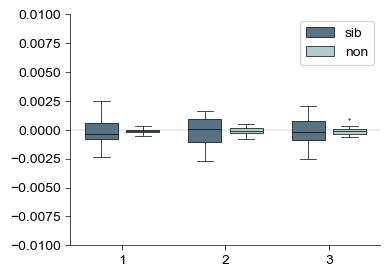

In [21]:
session, mat = compute_joint_probability_matrix(
            field_reg.astype(np.float64).T,
            field_info,
            dim=2,
            return_item='sib',
            field_centers=field_centers,
            sib_field_pairs=sp_field_pairs,
            non_field_pairs=nsp_field_pairs
)
session, mat2 = compute_joint_probability_matrix(
            field_reg.astype(np.float64).T,
            field_info,
            dim=2,
            return_item='non',
            field_centers=field_centers,
            sib_field_pairs=sp_field_pairs,
            non_field_pairs=nsp_field_pairs
)

print(mat.shape, mat2.shape)

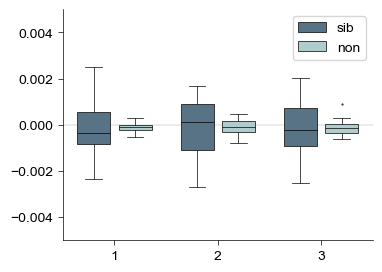

In [22]:
t = np.concatenate([np.arange(25)] * 3)
x = np.concatenate([np.repeat(1, 25), np.repeat(2, 25), np.repeat(3, 25)])
y1 = np.concatenate([mat[:, 0, 0], mat[:, 1, 1], mat[:, 2, 2]])
y2 = np.concatenate([mat2[:, 0, 0], mat2[:, 1, 1], mat2[:, 2, 2]])
fig = plt.figure(figsize=(4,3))
ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
ax.axhline(0, color='k', linestyle='--', linewidth=0.15)
sns.boxplot(
    x = np.concatenate([x, x]),
    y = np.concatenate([y1, y2]),
    hue = np.concatenate([np.repeat('sib', 75), np.repeat('non', 75)]),
    palette=['#4F758D', '#ABD0D1'],
    ax = ax,
    linecolor='black',
    linewidth=0.5,
    gap=0.2,
    flierprops={'markersize': 0.5},
)
ax.set_ylim([-0.005, 0.005])
plt.savefig(join(loc, "Pure SFER [position].png"), dpi=600)
plt.savefig(join(loc, "Pure SFER [position].svg"), dpi=600)

# SFER with correction

In [2]:
from mylib.field.field_tracker import indept_test_for_evolution_events, compute_joint_probability_matrix

D = GetDMatrices(1, 48)
thre = 50

print(SFER.field_reg.dtype)

sib_field_pairs, non_field_pairs = [], []
for i in tqdm(range(len(SFER.field_info)-1)):
    for j in range(i+1, len(SFER.field_info)):
        if SFER.field_info[i] == SFER.field_info[j]:
            if len(sib_field_pairs) >= 3000000:
                continue
            if D[int(SFER.field_pos[i])-1, int(SFER.field_pos[j])-1] <= thre:
                continue
                    
            sib_field_pairs.append([i, j])
            sib_field_pairs.append([j, i])
        else:
            if len(non_field_pairs) >= 200000000:
                continue
            non_field_pairs.append([i, j])
            non_field_pairs.append([j, i])
                
sib_field_pairs = np.array(sib_field_pairs)
non_field_pairs = np.array(non_field_pairs)

int64


  0%|          | 0/6117 [00:00<?, ?it/s]

100%|██████████| 6117/6117 [00:25<00:00, 243.28it/s] 


In [9]:
sib_field_pairs.shape, non_field_pairs.shape

((60800, 2), (35229252, 2))

In [3]:
session, mat = compute_joint_probability_matrix(
            SFER.field_reg.astype(np.float64).T,
            SFER.field_info,
            dim=2,
            return_item='sib',
            field_centers=SFER.field_pos,
            sib_field_pairs=sib_field_pairs,
            non_field_pairs=non_field_pairs
)
session, mat2 = compute_joint_probability_matrix(
            SFER.field_reg.astype(np.float64).T,
            SFER.field_info,
            dim=2,
            return_item='non',
            field_centers=SFER.field_pos,
            sib_field_pairs=sib_field_pairs,
            non_field_pairs=non_field_pairs
)

 init size  (65582, 2) (37346124, 2)
 after processed size  (29468, 2) (29468, 2)
 after processed size  (25872, 2) (25872, 2)
 after processed size  (24538, 2) (24538, 2)
 after processed size  (25704, 2) (25704, 2)
 after processed size  (26098, 2) (26098, 2)
 after processed size  (26280, 2) (26280, 2)
 init size  (65582, 2) (37346124, 2)
 after processed size  (29468, 2) (29468, 2)
 after processed size  (25872, 2) (25872, 2)
 after processed size  (24538, 2) (24538, 2)
 after processed size  (25704, 2) (25704, 2)
 after processed size  (26098, 2) (26098, 2)
 after processed size  (26280, 2) (26280, 2)


(6, 3, 3) (6, 3, 3)


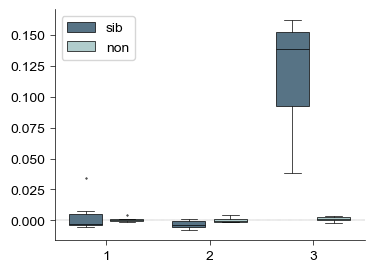

In [5]:
print(mat.shape, mat2.shape)
t = np.concatenate([np.arange(6)] * 3)
x = np.concatenate([np.repeat(1, 6), np.repeat(2, 6), np.repeat(3, 6)])
y1 = np.concatenate([mat[:, 0, 0], mat[:, 1, 1], mat[:, 2, 2]])
y2 = np.concatenate([mat2[:, 0, 0], mat2[:, 1, 1], mat2[:, 2, 2]])
fig = plt.figure(figsize=(4,3))
ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
ax.axhline(0, color='k', linestyle='--', linewidth=0.15)
sns.boxplot(
    x = np.concatenate([x, x]),
    y = np.concatenate([y1, y2]),
    hue = np.concatenate([np.repeat('sib', 18), np.repeat('non', 18)]),
    palette=['#4F758D', '#ABD0D1'],
    ax = ax,
    linecolor='black',
    linewidth=0.5,
    gap=0.2,
    flierprops={'markersize': 0.5},
)
plt.savefig(join(loc, "SFER + intrinsic stability.png"), dpi=600)
plt.savefig(join(loc, "SFER + intrinsic stability.svg"), dpi=600)